In [1]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import get_ensg_id, estimate_s, CCC

In [2]:
plt.rcParams['font.size'] = '12'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '18'
title_font = '30'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [4]:
rna = ad.read_loom('/home/mffang/data/counts/10x_pbmc_3k_2021/rna/counts_filtered/adata.loom',validate=False)
rna

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 2755 × 62754
    obs: 'barcode'
    var: 'target_name'
    layers: 'ambiguous', 'mature', 'nascent'

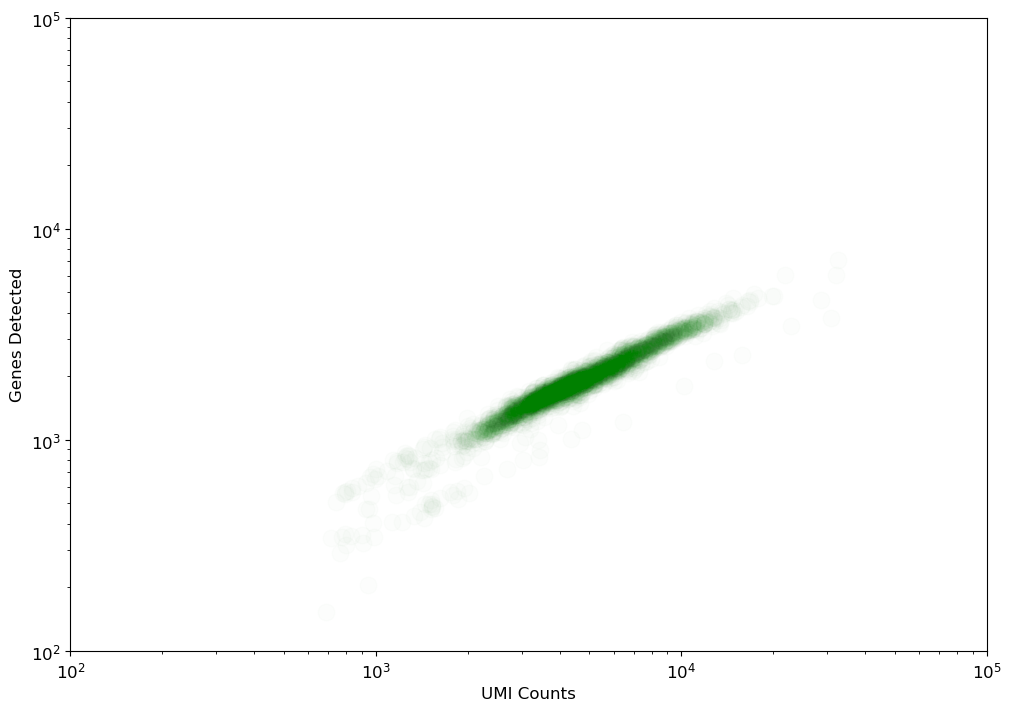

In [5]:
mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", alpha=0.01)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((100,100000))
ax.set_ylim((100,100000))

plt.show()

In [6]:
import statistics

statistics.median(mtx.sum(axis=1))

4387.0

In [7]:
rna.obs

,barcode
0,AAACAGCCAAATATCC
1,AAACAGCCAGGAACTG
2,AAACAGCCAGGCTTCG
3,AAACCAACACCTGCTC
4,AAACCAACAGATTCAT
...,...
2750,TTTGTGGCATTAGCCA
2751,TTTGTGGCATTGCGAC
2752,TTTGTGTTCCGCCTAT
2753,TTTGTGTTCCGTGACA


In [34]:
meta = pd.read_csv('/home/mffang/data/counts/10x_pbmc_3k_2021/analysis/clustering/gex/graphclust/clusters.csv')
meta

,Barcode,Cluster
0,AAACAGCCAAATATCC-1,6
1,AAACAGCCAGGAACTG-1,3
2,AAACAGCCAGGCTTCG-1,4
3,AAACCAACACCTGCTC-1,7
4,AAACCAACAGATTCAT-1,6
...,...,...
2706,TTTGTGGCATTAGCCA-1,1
2707,TTTGTGGCATTGCGAC-1,6
2708,TTTGTGTTCCGCCTAT-1,1
2709,TTTGTGTTCCGTGACA-1,6


In [35]:
meta_bcd = np.array([name[:-2] for name in meta['Barcode']],dtype=str)
meta['bcs'] = meta_bcd
meta

,Barcode,Cluster,bcs
0,AAACAGCCAAATATCC-1,6,AAACAGCCAAATATCC
1,AAACAGCCAGGAACTG-1,3,AAACAGCCAGGAACTG
2,AAACAGCCAGGCTTCG-1,4,AAACAGCCAGGCTTCG
3,AAACCAACACCTGCTC-1,7,AAACCAACACCTGCTC
4,AAACCAACAGATTCAT-1,6,AAACCAACAGATTCAT
...,...,...,...
2706,TTTGTGGCATTAGCCA-1,1,TTTGTGGCATTAGCCA
2707,TTTGTGGCATTGCGAC-1,6,TTTGTGGCATTGCGAC
2708,TTTGTGTTCCGCCTAT-1,1,TTTGTGTTCCGCCTAT
2709,TTTGTGTTCCGTGACA-1,6,TTTGTGTTCCGTGACA


In [37]:
meta['bcs'].isin(rna.obs['barcode']).sum()

2684

In [45]:
meta['Cluster'][meta_common_bc_idx]

0       6
1       3
2       4
3       7
4       6
       ..
2706    1
2707    6
2708    1
2709    6
2710    7
Name: Cluster, Length: 2684, dtype: int64

In [71]:
rna_bcd = rna.obs['barcode']
meta_bcd = meta['bcs']
common_bc = np.intersect1d(meta_bcd,np.array(rna_bcd))
print(common_bc.shape)
meta_common_bc_idx = np.array([np.where(np.array(meta_bcd)==bc)[0][0] for bc in common_bc])
rna_common_bc_idx = np.array([np.where(np.array(rna_bcd)==bc)[0][0] for bc in common_bc])

rna = rna[rna_common_bc_idx]
rna.obs['Clusters'] = np.array(meta['Cluster'][meta_common_bc_idx],dtype=int)

(2684,)


/tmp/ipykernel_1784883/1799506575.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna.obs['Clusters'] = np.array(meta['Cluster'][meta_common_bc_idx],dtype=int)


In [72]:
rna.obs

,barcode,Clusters
0,AAACAGCCAAATATCC,6
1,AAACAGCCAGGAACTG,3
2,AAACAGCCAGGCTTCG,4
3,AAACCAACACCTGCTC,7
4,AAACCAACAGATTCAT,6
...,...,...
2750,TTTGTGGCATTAGCCA,1
2751,TTTGTGGCATTGCGAC,6
2752,TTTGTGTTCCGCCTAT,1
2753,TTTGTGTTCCGTGACA,6


In [9]:
protein = pd.read_csv('data/CITE-seq/GSE100866_PBMC_vs_flow_10X-ADT_umi.csv')
protein = protein.T
protein.columns = protein.iloc[0]
protein = protein[1:]
protein = ad.AnnData(protein)
protein

AnnData object with n_obs × n_vars = 7985 × 10

In [10]:
protein.obs_names

Index(['ACCGTAAGTGTAATGA', 'CGTGAGCTCGAGAACG', 'CACATTTAGAATTCCC',
       'TACGGTATCTGGGCCA', 'TCAGGTAGTAAGTTCC', 'TGATTTCGTTCTCATT',
       'ACACTGAAGGCCCTCA', 'ACGGGTCGTCACACGC', 'AGCTTGACATCCCATC',
       'ACGTCAATCCGTCATC',
       ...
       'TTCTCCTAGATCGATA', 'GGAAAGCGTCGACTAT', 'GACTAACCAACACCCG',
       'AGCGTCGTCCTCGCAT', 'TCTCATAAGTTTGCGT', 'GTCGGGTAGAGCTGGT',
       'GTCGGGTAGGTAGCCA', 'GTCGGGTAGTCTTGCA', 'ATGTGTGGTCCGTTAA',
       'CGTATGCCGTCTTCTG'],
      dtype='object', length=7985)

In [11]:
rna_bcd = rna.obs_names
protein_bcd = protein.obs_names
bcd = [ bc[11:-1]   for bc in rna_bcd]
common_bc = np.intersect1d(bcd,np.array(protein_bcd))
print(common_bc.shape)

protein_common_bc_idx = np.array([np.where(np.array(protein_bcd)==bc)[0][0] for bc in common_bc])
rna_common_bc_idx = np.array([np.where(np.array(bcd)==bc)[0][0] for bc in common_bc])

rna = rna[rna_common_bc_idx]
protein = protein[protein_common_bc_idx]

(1780,)


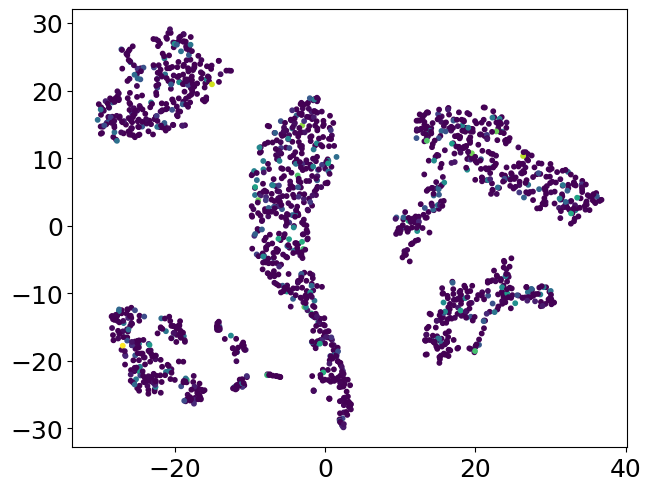

In [12]:
plt.scatter(rna.obs['_X'],rna.obs['_Y'],c=protein.X[:,2],s=10)

In [13]:
genes = np.array(protein.var_names,dtype=str)
genes

array(['CD3', 'CD4', 'CD8', 'CD2', 'CD45RA', 'CD57', 'CD16', 'CD14',
       'CD11c', 'CD19'], dtype='<U6')

In [14]:
ensg_ids = []
# Example usage
for gene in genes:
    gene_name = gene
    ensg_id = get_ensg_id(gene_name)
    ensg_ids.append(ensg_id)
    if ensg_id:
        print(f"The ENSG ID for gene {gene_name} is: {ensg_id}")
    else:
        print(f"Failed to retrieve ENSG ID for gene {gene_name}")

Failed to retrieve ENSG ID for gene CD3
The ENSG ID for gene CD4 is: ENSG00000010610
The ENSG ID for gene CD8 is: ENSG00000153563
The ENSG ID for gene CD2 is: ENSG00000116824
Failed to retrieve ENSG ID for gene CD45RA
The ENSG ID for gene CD57 is: ENSG00000109956
The ENSG ID for gene CD16 is: ENSG00000203747
The ENSG ID for gene CD14 is: ENSG00000170458
The ENSG ID for gene CD11c is: ENSG00000140678
The ENSG ID for gene CD19 is: ENSG00000177455


In [15]:
ensg_ids[0] = 'ENSG00000167286' #CD3 delta
ensg_ids[4] = 'ENSG00000081237' #CD45 (PTPRC)
ensg_ids

['ENSG00000167286',
 'ENSG00000010610',
 'ENSG00000153563',
 'ENSG00000116824',
 'ENSG00000081237',
 'ENSG00000109956',
 'ENSG00000203747',
 'ENSG00000170458',
 'ENSG00000140678',
 'ENSG00000177455']

In [16]:
gene_idx = [ np.where(np.array(rna.var['Accession']) == ensg_id)[0][0] for ensg_id in ensg_ids]
gene_idx

[5211, 7261, 17878, 2370, 2828, 5325, 1090, 25619, 12428, 12355]

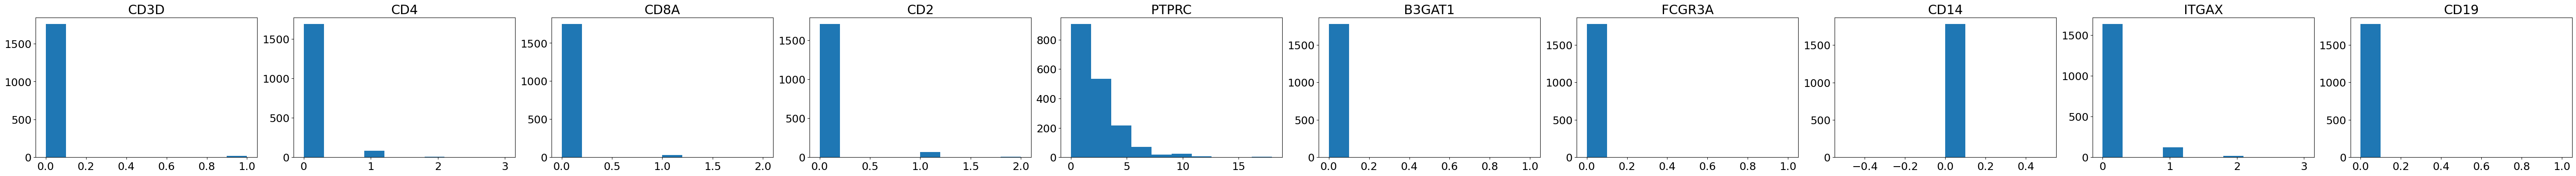

In [17]:
fig, ax = plt.subplots(1,10,figsize=(60,4))
i = 0
for idx in gene_idx:
    ax[i].set_title(rna.var_names[idx])
    ax[i].hist(rna.layers['unspliced'].toarray()[:,idx],bins=10);
    i = i+1

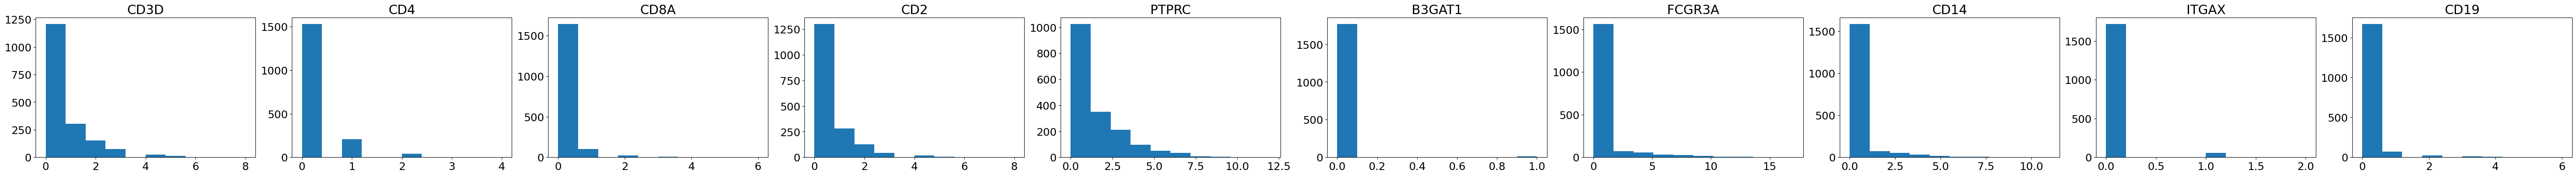

In [18]:
fig, ax = plt.subplots(1,10,figsize=(60,4))
i = 0
for idx in gene_idx:
    ax[i].set_title(rna.var_names[idx])
    ax[i].hist(rna.layers['spliced'].toarray()[:,idx],bins=10);
    i = i+1

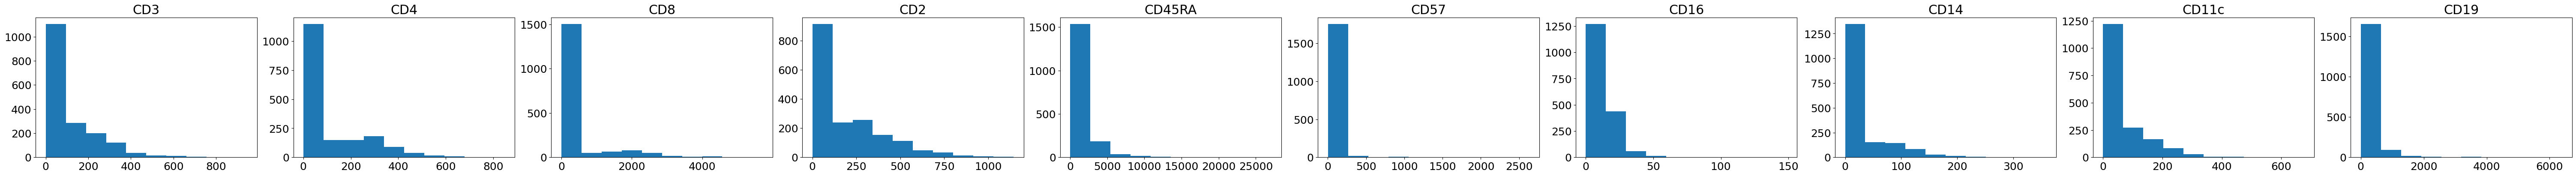

In [19]:
fig, ax = plt.subplots(1,10,figsize=(60,4))

for i in range(10):
    ax[i].set_title(protein.var_names[i])
    ax[i].hist(protein.X.toarray()[:,i],bins=10);
    i = i+1

## Calculate CV$^2$ of read depth

In [151]:
adata = rna
adata.layers['unspliced'] = adata.layers['nascent'] + adata.layers['ambiguous']
adata.layers['spliced'] = adata.layers['mature']

In [152]:
clusters = adata.obs["Clusters"]
Clusters = set(clusters)
Clusters

{1, 2, 3, 4, 5, 6, 7, 8}

0.06928008 0.012317827


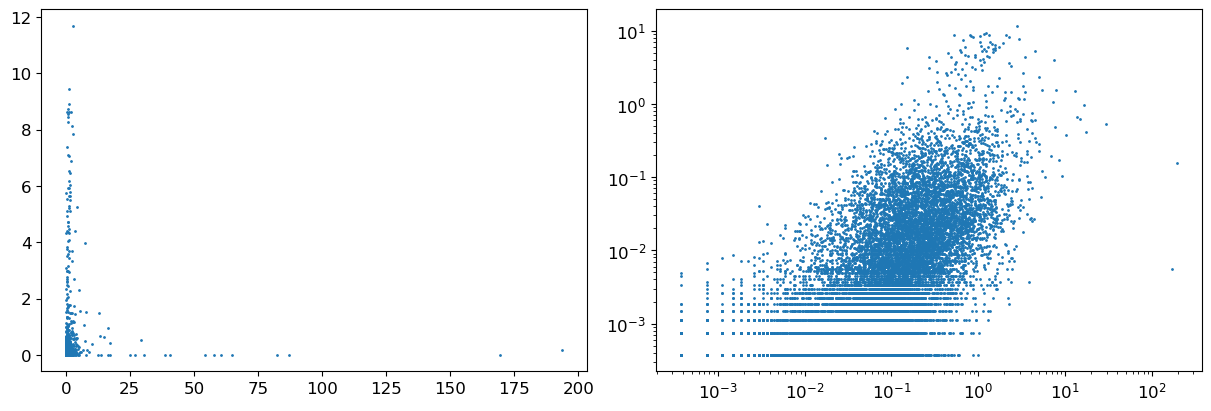

In [153]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

s estimated by total counts = 0.2675173730343998
830 su= 0.2573101078801467
6057 ss= 0.37851764090175305
484 s= 0.22459612952538444


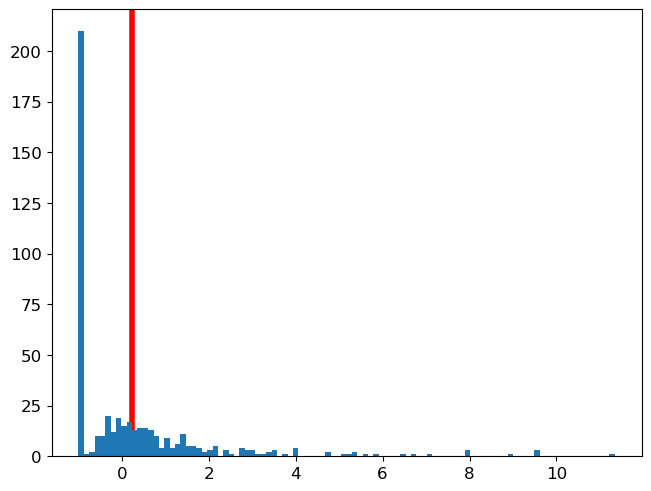

In [156]:
su, ss, sp = estimate_s(adata,min_mean=0.001)

In [157]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.0) & (adata.layers["unspliced"].toarray().mean(0) > 0.0)
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
U.sum(),S.sum()

(9205084.0, 2074486.0)

Text(0.02, 0.5, 'CV$^2$')

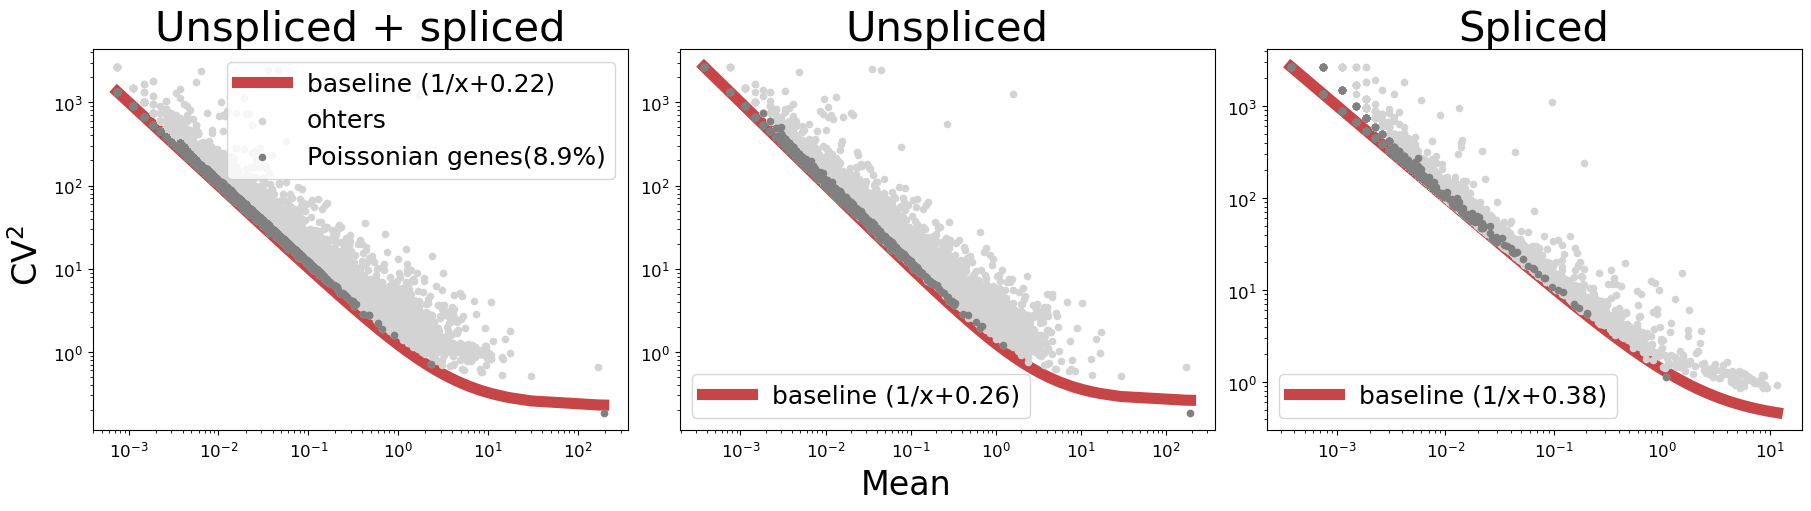

In [158]:
X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

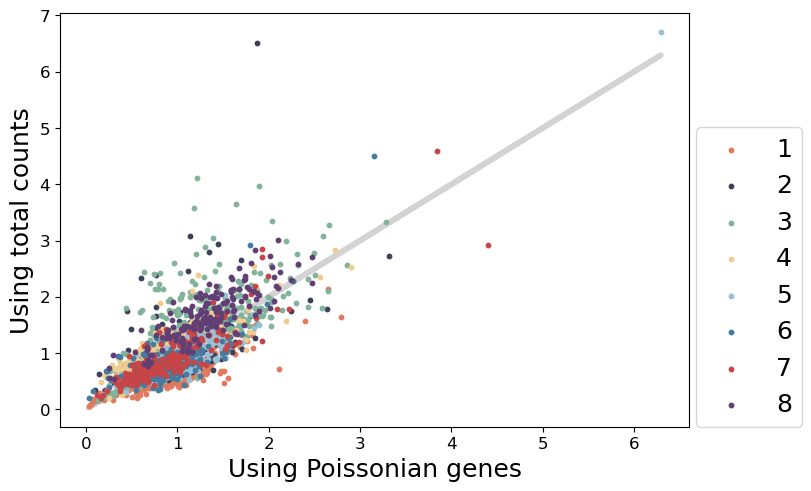

In [159]:
clusters = adata.obs["Clusters"]

rd = X[:,Pgene_mask].mean(1)/X[:,Pgene_mask].mean()
rd_ = X.mean(1)/X.mean()
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
for i,Cluster in enumerate(Clusters):
    idx = clusters.isin([Cluster])
    ax.scatter(rd[idx],rd_[idx],color=cmap_cluster(i),alpha=1,s=10,label=Cluster)
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)
plt.legend(loc=(1.01,0),fontsize=legend_font)

## Select one cluster and calculate CV again

In [160]:
for i in Clusters:
    print(i,rna.obs['Clusters'].isin([i]).sum())

1 496
2 417
3 410
4 358
5 347
6 267
7 220
8 169


In [161]:
cluster_idx = rna.obs['Clusters'].isin([1]) # 8
adata = rna[cluster_idx]
adata

View of AnnData object with n_obs × n_vars = 496 × 62754
    obs: 'barcode', 'Clusters'
    var: 'target_name'
    layers: 'ambiguous', 'mature', 'nascent', 'unspliced', 'spliced'

s estimated by total counts = 0.13888895844888802
753 su= 0.12091543909514485
2201 ss= 0.15804315384717327
445 s= 0.1382571402710597


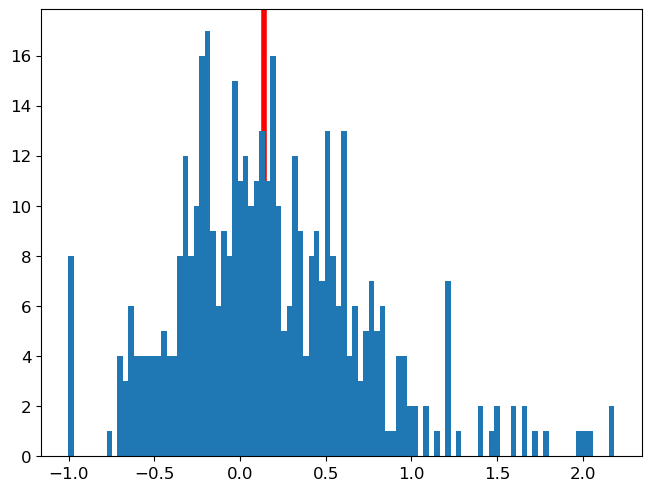

In [162]:
su, ss, sp = estimate_s(adata)

Text(0.02, 0.5, 'CV$^2$')

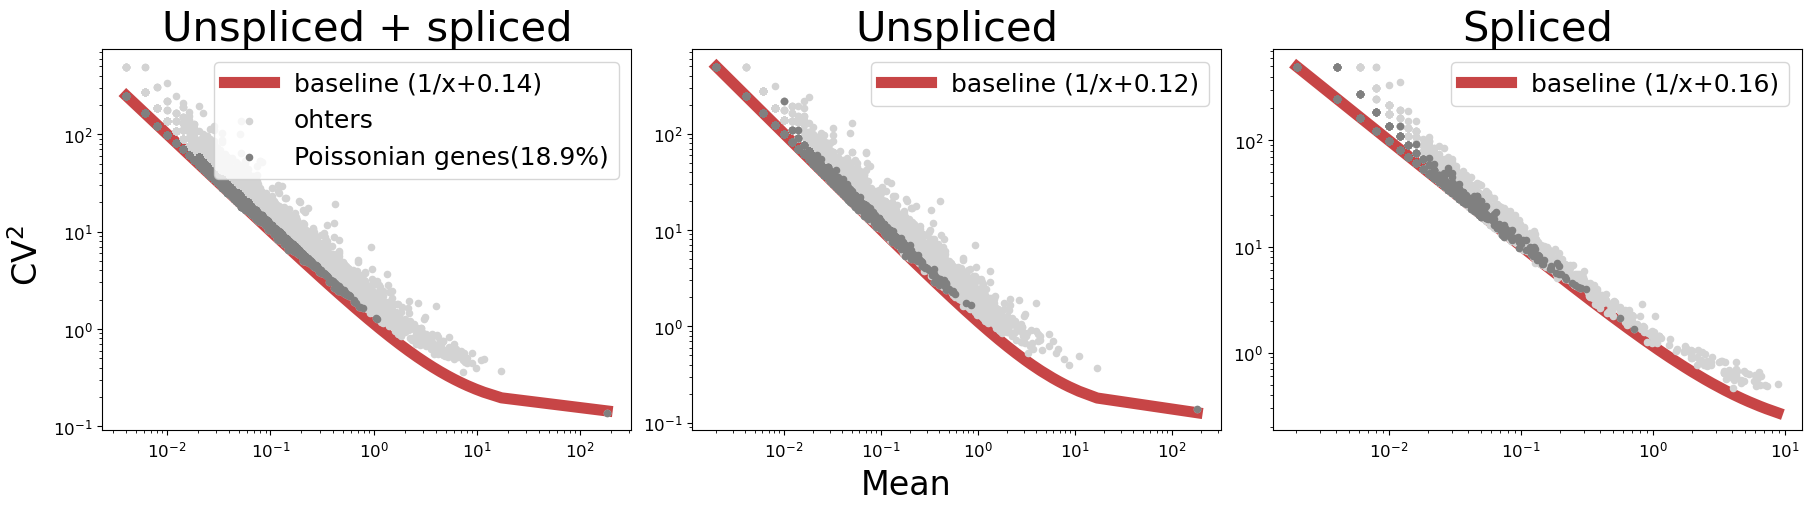

In [163]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.0) & (adata.layers["unspliced"].toarray().mean(0) > 0.0)
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()

X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

Text(0.02, 0.5, 'CV$^2$')

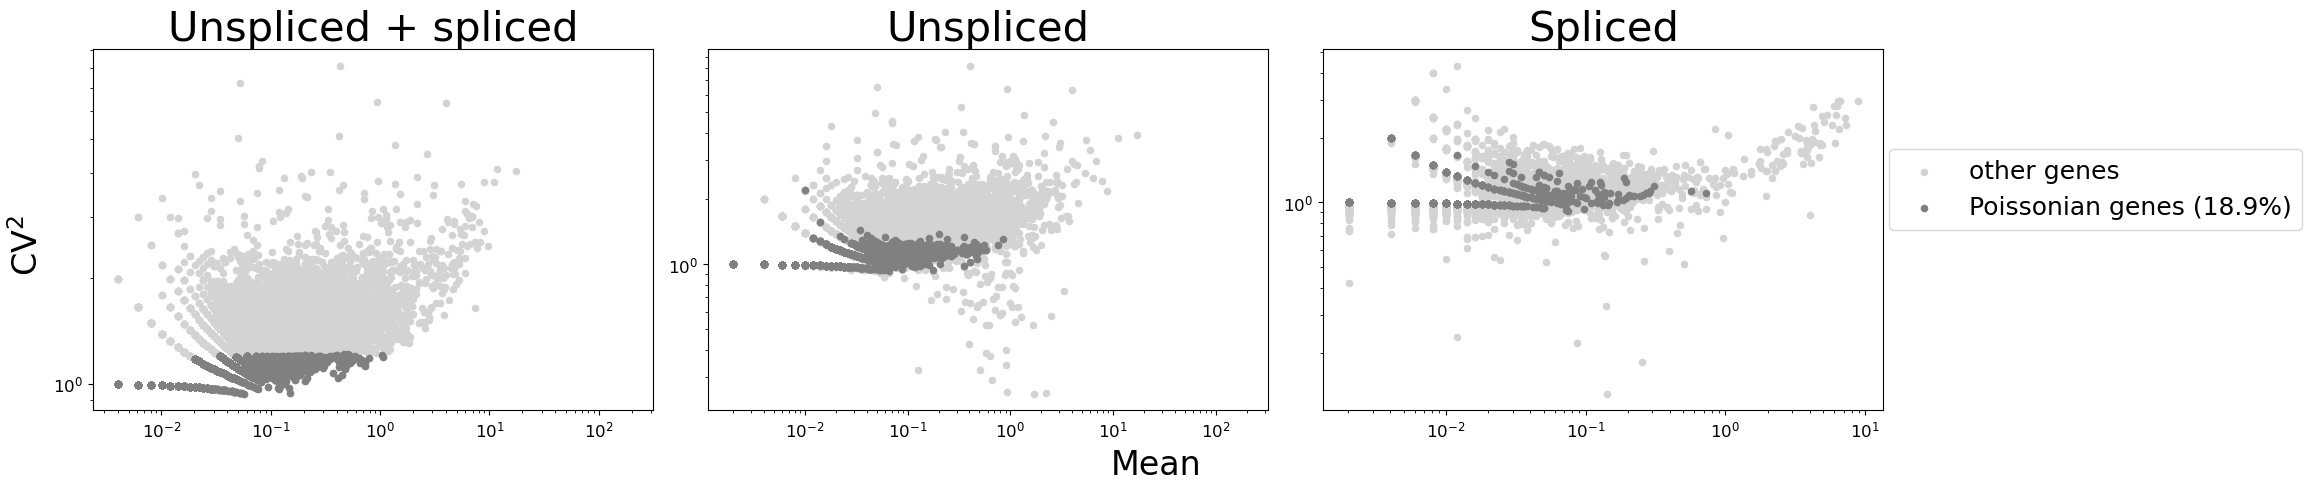

In [164]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.0) & (adata.layers["unspliced"].toarray().mean(0) > 0.0)
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()

X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2) 

fig, ax = plt.subplots(1,3,figsize=(23,4.8))

ax[0].scatter(X_mean, X_var/X_mean-sp*X_mean,c='lightgray',alpha=1, s=20)
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask], s=20, c='gray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)

ax[1].scatter(U_mean, U_var/U_mean-sp*X_mean,c='lightgray',alpha=1, s=20, label='other genes')
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]-sp*U_mean[Pgene_mask], s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)

ax[2].scatter(S_mean, S_var/S_mean-sp*X_mean,c='lightgray',alpha=1, s=20, label='other genes')
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]-sp*S_mean[Pgene_mask], s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)

ax[2].legend(loc=(1.01,0.5),fontsize=legend_font)
fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

0.18901970821602251


Text(0.5, 1.0, 'U+S+A')

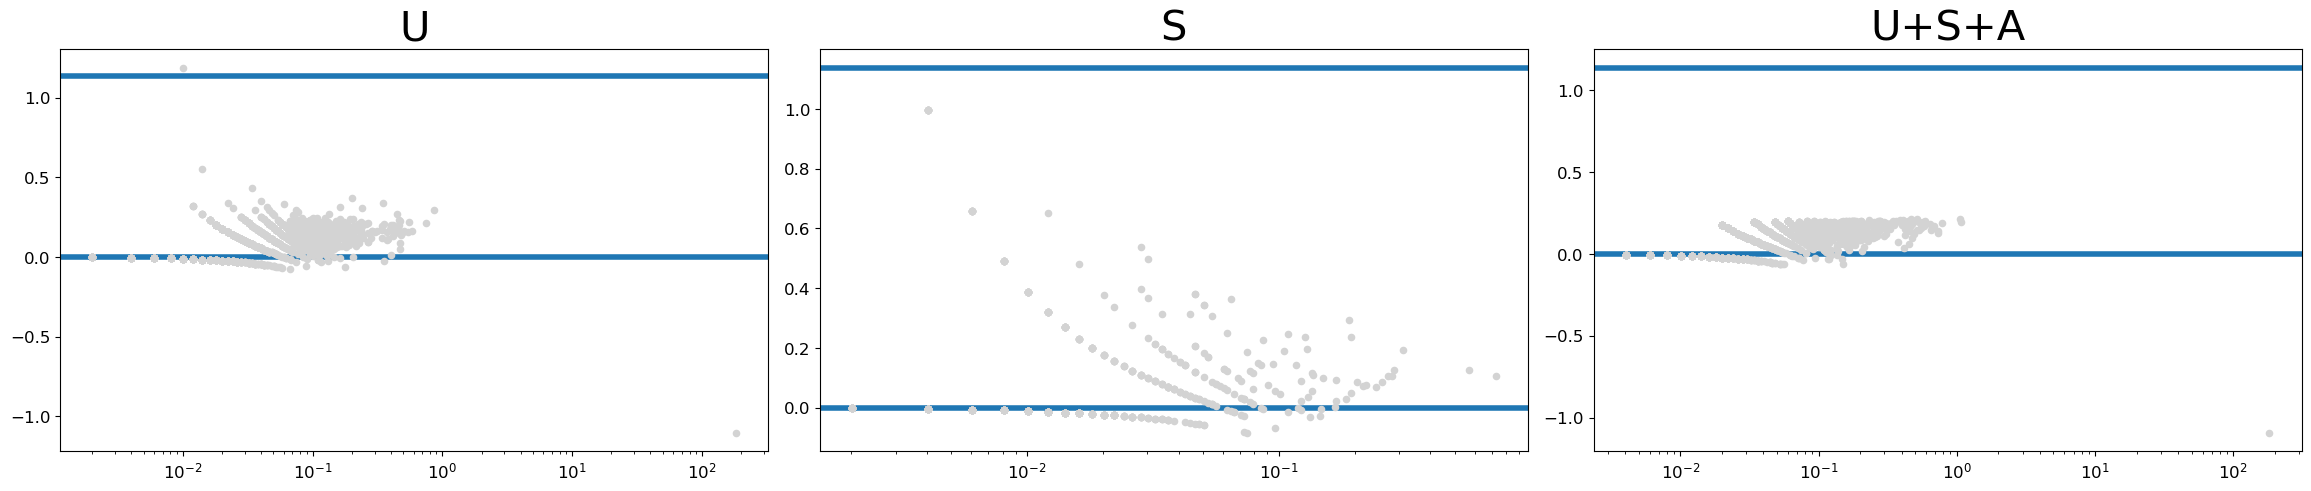

In [165]:
print(Pgene_mask.mean())
s=sp
def f(X):
    mean = np.mean(X,axis=0)
    var = np.var(X,axis=0)
    return var/mean-s*mean-1

fig, ax = plt.subplots(1,3,figsize=(23,4.8))
ax[0].scatter(U_mean[Pgene_mask], f(U[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[0].axhline(y=0,zorder=0)
ax[0].axhline(y=1+s,zorder=0)
ax[0].set_xscale('log')
ax[0].set_title('U',fontsize=title_font)

ax[1].scatter(S_mean[Pgene_mask], f(S[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[1].axhline(y=0,zorder=0)
ax[1].axhline(y=1+s,zorder=0)
ax[1].set_xscale('log')
ax[1].set_title('S',fontsize=title_font)

X_ = S + U 
ax[2].scatter(X_mean[Pgene_mask], f(X_[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[2].axhline(y=0,zorder=0)
ax[2].axhline(y=1+s,zorder=0)
ax[2].set_xscale('log')
ax[2].set_title('U+S+A',fontsize=title_font)

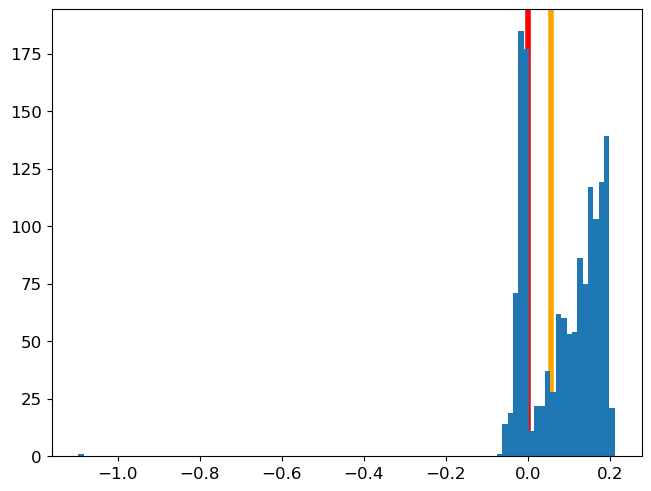

In [166]:
plt.hist((X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask],bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.axvline(x=0.05*(1+s),c='orange',zorder=0)

# Check covariance relationships

In [172]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.2) & (adata.layers["unspliced"].toarray().mean(0) > 0.2)

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
A = adata.layers["ambiguous"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean
zeta_us.shape

(209,)

## Var(N_U)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


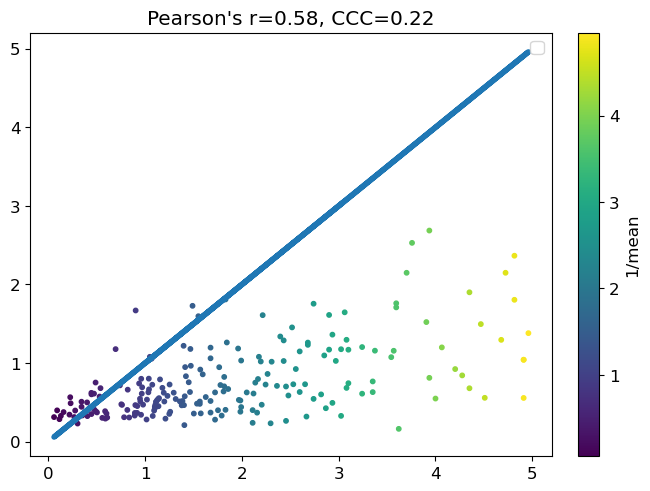

In [173]:
x = 1/U_mean
y = zeta_uu
plt.scatter(x,y,s=10,alpha=1,c=x)
plt.plot(x,x)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

Text(0.5, 1.0, '100.0% of cells >= 0')

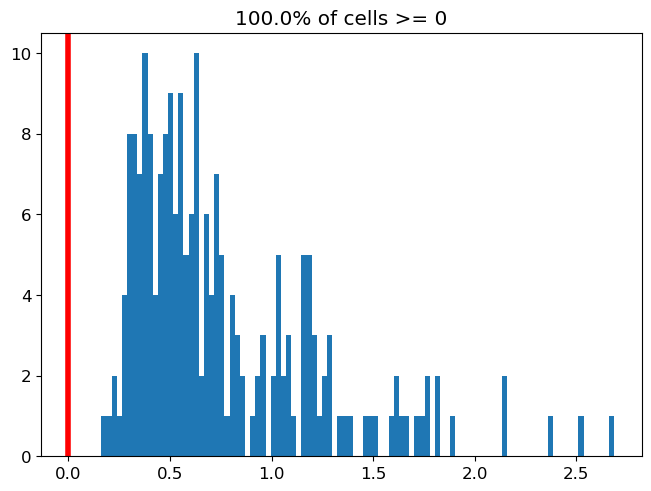

In [174]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r')
plt.title(str(np.around(100*(zeta_uu>=0).mean(),2))+'% of cells >= 0')

## Cov(N_u,N_s)
$$\zeta_{us}<\zeta_{uu}$$

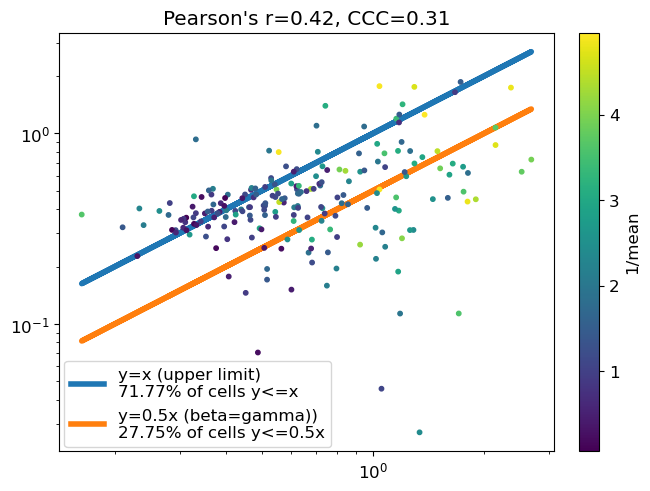

In [175]:
x=zeta_uu
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(loc=(0.01,0.01))

## Var(N_s)

$$\zeta_{ss}=\zeta_{us}$$

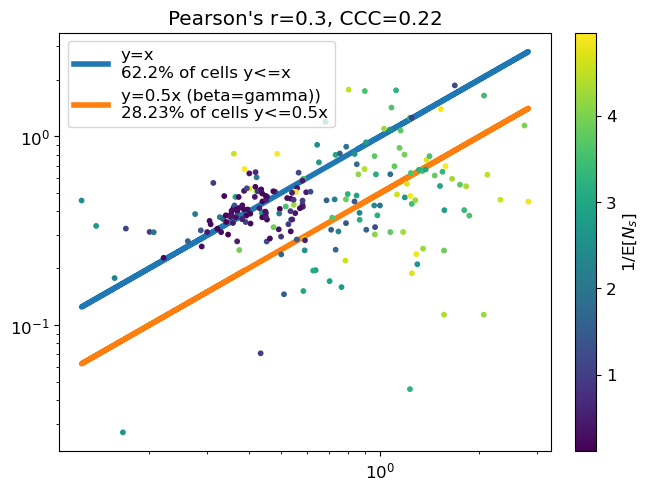

In [176]:
x=zeta_ss
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

# Check protein varaince

In [78]:
U = adata.layers["unspliced"].toarray()[:,gene_idx]
S = adata.layers["spliced"].toarray()[:,gene_idx]
P = np.array(protein.X.toarray()[cluster_idx],dtype=int)
P.shape

(340, 10)

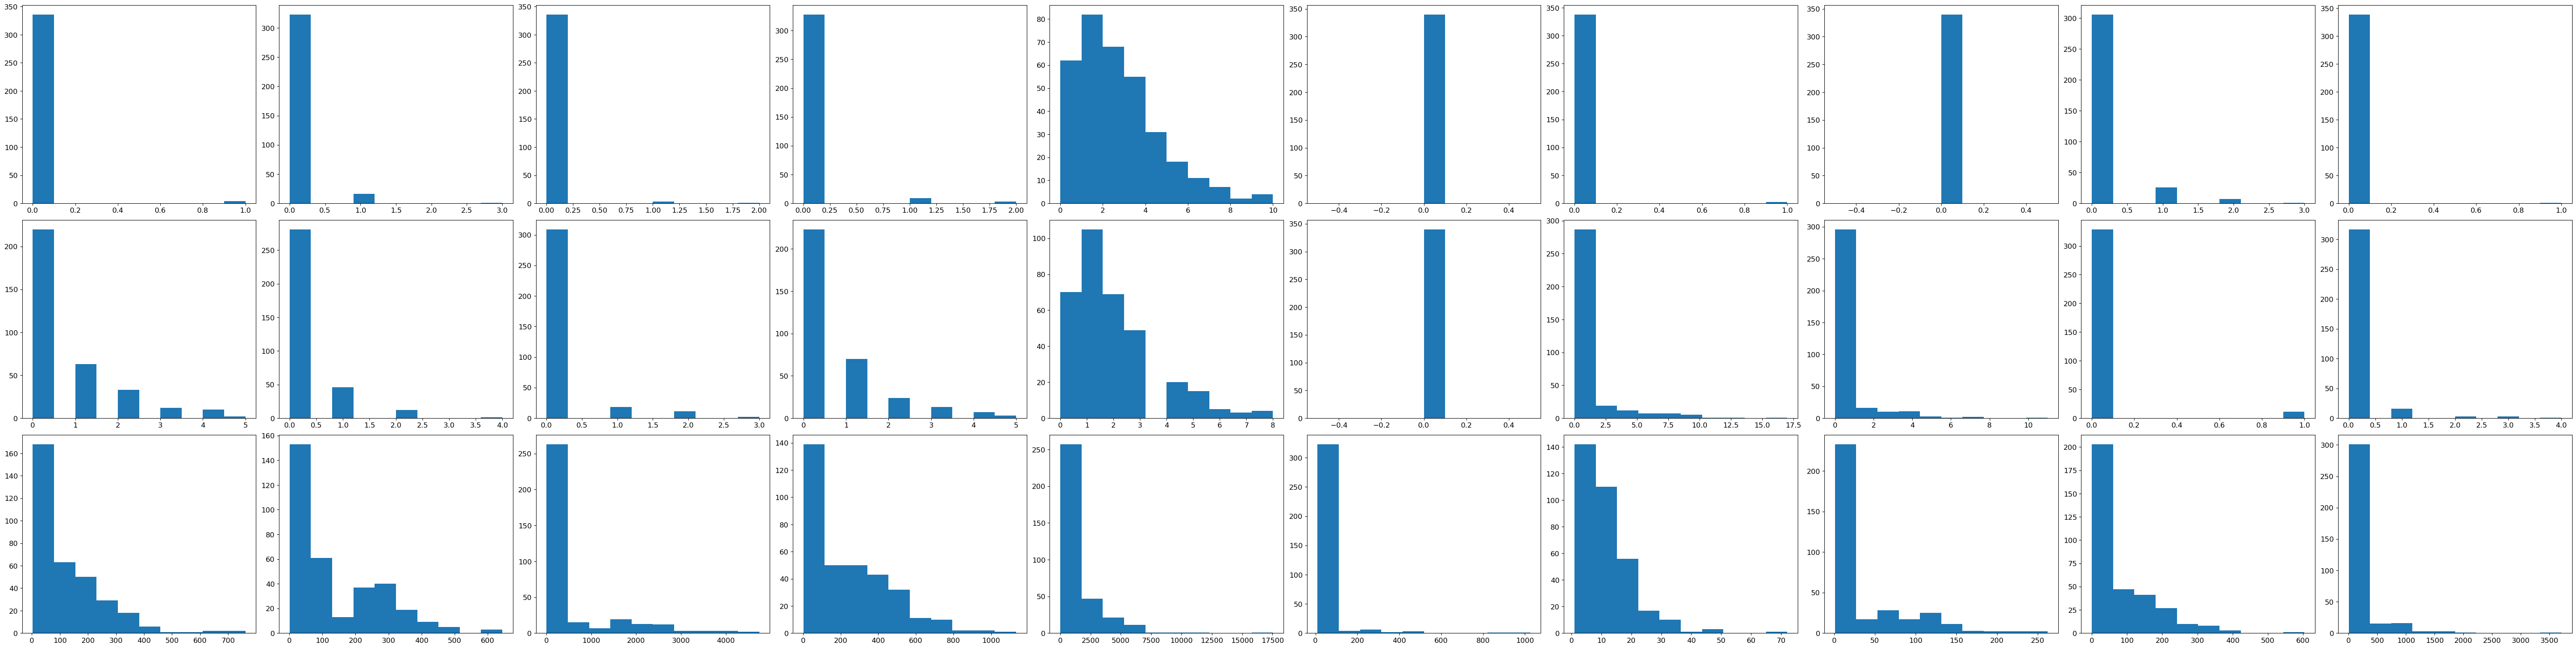

In [79]:
fig,ax = plt.subplots(3,10,figsize=(60,15))
for i in range(10):
    ax[0,i].hist(U[:,i])
    ax[1,i].hist(S[:,i])
    ax[2,i].hist(P[:,i])

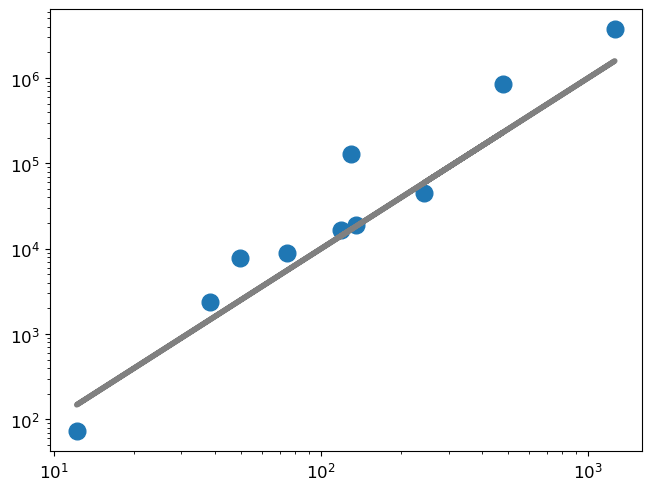

In [80]:
plt.scatter(P.mean(0),P.var(0))
plt.loglog(P.mean(0),P.mean(0)**2,'gray')

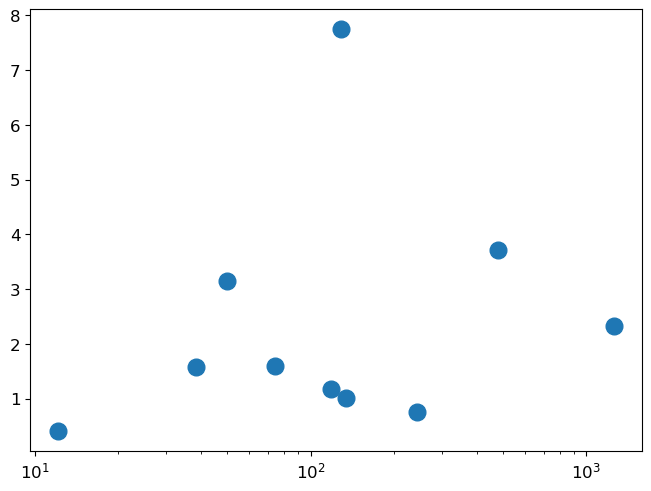

In [81]:
plt.scatter(P.mean(0),(P.var(0)-P.mean(0))/P.mean(0)**2)
plt.xscale('log')

In [82]:
iidx = (np.mean(U,axis=0)>0) &  (np.mean(S,axis=0)>0) &  (np.mean(P,axis=0)>0)
U = U[:,iidx]
S = S[:,iidx]
P = P[:,iidx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
P_mean = np.mean(P,axis=0)
P_var = np.var(P,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_pp = (P_var-P_mean)/P_mean**2
zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
cov_up = []
cov_sp = []
for i in range(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
    cov_up.append(np.cov(U[:,i],P[:,i])[0,1])
    cov_sp.append(np.cov(S[:,i],P[:,i])[0,1])
    
zeta_us = (np.array(cov_us)/U_mean/S_mean)
zeta_up = (np.array(cov_up)/U_mean/P_mean)
zeta_sp = (np.array(cov_sp)/S_mean/P_mean)
zeta_us

array([ 2.56568567, -0.27534754,  4.92753623,  1.8387414 ,  0.19829254,
        8.00042836,  2.60173249,  8.73999157])

## $Cov(N_u,N_p)$ 
$$ \gamma_p \zeta_{us} = (\gamma_p + \beta) \zeta_{up} $$  

In [83]:
zeta_up,zeta_us

(array([ 1.23711101,  1.01301436,  3.68821146,  0.97593109,  0.20403315,
         0.06886793,  0.98604154, 14.22379148]),
 array([ 2.56568567, -0.27534754,  4.92753623,  1.8387414 ,  0.19829254,
         8.00042836,  2.60173249,  8.73999157]))

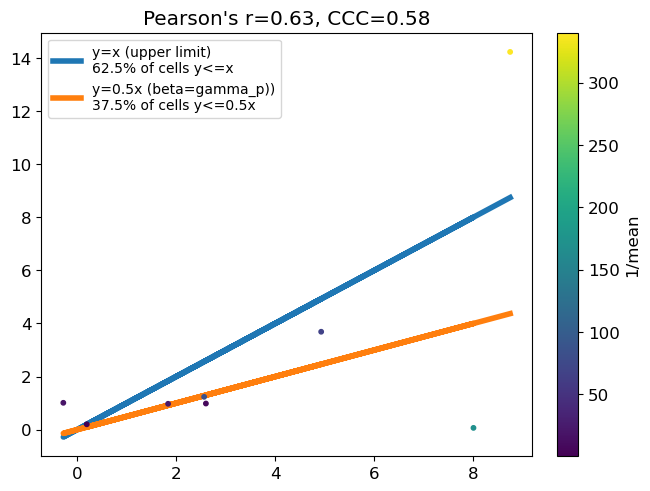

In [84]:
x=zeta_us
y=zeta_up

plt.plot(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma_p))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(fontsize=10)

## $Cov(N_s,N_p)$ 

$$\gamma (\zeta_{up}-\zeta_{sp}) + \gamma_p (\zeta_{ss}-\zeta_{sp}) = -\frac{\gamma_p}{\overline{X_s}} $$

In [85]:
zeta_up-zeta_sp,(zeta_up-zeta_sp)/(zeta_ss-zeta_sp)

(array([ 0.45357414,  0.65412781,  1.03778763,  0.33179173,  0.19208809,
        -0.60624778, -0.38086888,  5.6323643 ]),
 array([ 1.11074676,  0.74644718,  0.57250484,  0.50977384,  0.74721531,
        -0.12913643,  0.16091394, 14.06650829]))

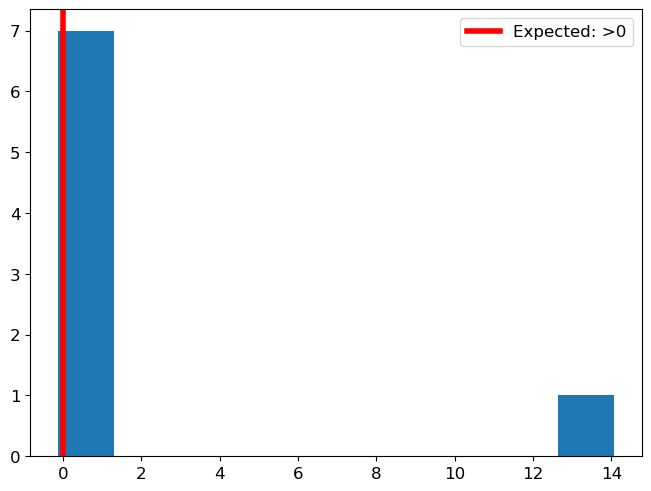

In [86]:
plt.hist((zeta_up-zeta_sp)/(zeta_ss-zeta_sp));
plt.axvline(x=0,c='r',label='Expected: >0')
plt.legend()

## $Var(N_p)$ 
$$ \zeta_{sp} = \zeta_{pp} $$  

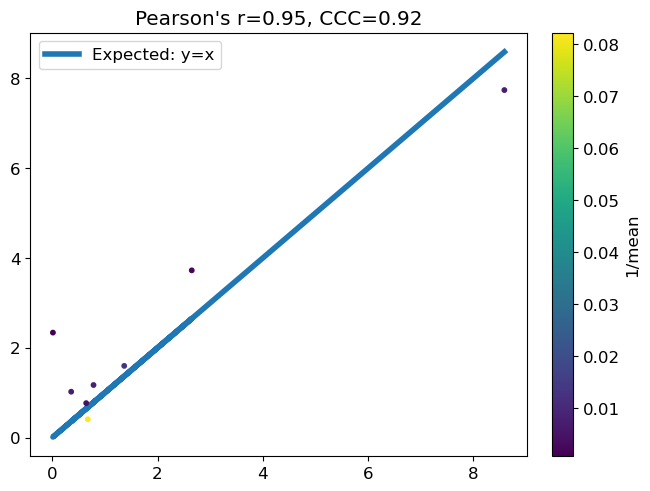

In [87]:
x=zeta_sp
y=zeta_pp

plt.plot(x,x,zorder=0,label='Expected: y=x')
plt.scatter(x,y,s=10,alpha=1,c=1/P_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()